# Reproduction of Figure 5B analysis of spike rate response to stimulation amplitude
# This file loads pre-sorted spikes and conducts a windowed analysis of spike rate responses after stimulation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.extractors as sse
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
import seaborn as sns

/home/laurendiaz/miniconda3/envs/oipls/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/laurendiaz/miniconda3/envs/oipls/lib/python3.10/site-packages/tridesclous/numba_tools.py:11: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True)
/home/laurendiaz/miniconda3/envs/oipls/lib/python3.10/site-packages/tridesclous/numba_tools.py:33: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argum

In [3]:
viridis = mpl.colormaps['viridis']
mpl.rcParams.update({'font.size': 15})

In [4]:
def pull_spike_data(fpath, recording, nwbfile, unit, bandpass = True, freqmin = 300, freqmax = 6000, artifact = 10):
    '''
    This function pulls and returns the max amplitude 
    and spike times for a given recording
    
    Parameters
    fpath (string)   : the  path to the folder containing your 
                       waveforms folder and .npy file (if current  
                       folder, input '.')
    unit (int)       : the unit you would like to analyze
    nwbfile (string) : the path to the nwb file with
                     raw recording 

    Return
    spike_amps (array):  1D array of spike amplitudes for given unit
    spike_times (array): 1D array of spike times for given unit
    '''
    # get raw recording data
    nwb_rec = se.read_nwb(fpath+'NWBFiles/'+nwbfile, electrical_series_name='ES')
    #rec_data = pd.DataFrame(nwb_rec.get_traces())
    if(bandpass):
        nwb_rec_filtered = spre.bandpass_filter(nwb_rec, freq_min=freqmin, freq_max=freqmax)
        nwb_rec_preprocessed = spre.whiten(nwb_rec_filtered, dtype='float32')
        channel = nwb_rec_preprocessed.get_traces()[:,0]
        stimulation_trigger_frames = np.where(np.abs(channel)>artifact)
        nwb_rec = spre.remove_artifacts(nwb_rec_preprocessed,
                                        list_triggers=stimulation_trigger_frames[0].tolist(),
                                        ms_before=10, ms_after=10)

    # get spike data
    #spike_amps = np.load(fpath+f'spikingdata/{recording}waveforms_folder/spike_amplitudes/amplitude_segment_0.npy') 
    #print(spike_amps)
    spike_times = np.load(fpath+f'spikesorting/{recording}spikes.npy', allow_pickle=True) 
    
    #if(spike_amps.size == spike_times[0].size):
    return spike_times[unit], nwb_rec

In [5]:
def plot_stim_window(spiketimes, unit, amp, stim_start, stim_end, T):
    # T = time in seconds before/after stim to look at


    ''' 2) plot window for each stimulation '''
    fig, ax = plt.subplots(3,1, figsize=(10,15))

    # stimulation 1
    stim1_window_spikes = spiketimes[spiketimes > stim_start[0] - T]
    stim1_window_spikes = stim1_window_spikes[stim1_window_spikes < stim_end[0] + T]

    ax[0].eventplot(stim1_window_spikes)
    ax[0].axvspan(stim_start[0], stim_end[0], color=viridis(0.8), alpha=0.5)
    ax[0].set_xlim(stim_start[0] - T, stim_end[0] + T)
    ax[0].set_title('Stimulation 1')

    # stimulation 2
    stim2_window_spikes = spiketimes[spiketimes > stim_start[1] - T]
    stim2_window_spikes = stim2_window_spikes[stim2_window_spikes < stim_end[1] + T]

    ax[1].eventplot(stim2_window_spikes)
    ax[1].axvspan(stim_start[1], stim_end[1], color=viridis(0.8), alpha=0.5)
    ax[1].set_xlim(stim_start[1] - T, stim_end[1] + T)
    ax[1].set_title('Stimulation 2')

    # stimulation 3
    stim3_window_spikes = spiketimes[spiketimes > stim_start[2] - T]
    stim3_window_spikes = stim3_window_spikes[stim3_window_spikes < stim_end[2] + T]

    ax[2].eventplot(stim3_window_spikes)
    ax[2].axvspan(stim_start[2], stim_end[2], color=viridis(0.8), alpha=0.5)
    ax[2].set_xlim(stim_start[2] - T, stim_end[2] + T)
    ax[2].set_title('Stimulation 3')

    fig.suptitle(f'BO2 11/17/23 Unit {unit}\nSpikes Around Stimulation of {amp} uA, T = {T}', fontsize=20)

    # prepare output
    spike_windows = [stim1_window_spikes, stim2_window_spikes, stim3_window_spikes]
    return spike_windows

In [6]:
fpath = '../data/Organoid_Batch14/'

# 5uA

This day had 3 main bursts of stimulation as follows
1) +/-0.005 @ 30.835000 - 30.835433 
2) +/-0.005 @ 44.941800 - 44.942233 
3) +/-0.005 @ 60.141900 - 60.142333 

In [7]:
stim1_start_5uA  = 30.835000
stim1_end_5uA  = 30.835433

stim2_start_5uA  = 44.941800
stim2_end_5uA  = 44.942233

stim3_start_5uA  = 60.141900
stim3_end_5uA  = 60.142333

In [8]:
stims_start_5uA = [stim1_start_5uA, stim2_start_5uA, stim3_start_5uA]

stims_end_5uA = [stim1_end_5uA, stim2_end_5uA, stim3_end_5uA]

## Unit 1

In [9]:
spiketimes_5uA_unit1, nwb_5uA_unit1 = pull_spike_data(fpath, 'BO2_231117_Stim5uA', 'BO2W1Stim_111723_5uA233uS.nwb', 0)
spiketimes_5uA_sec_unit1 = spiketimes_5uA_unit1 / 30000

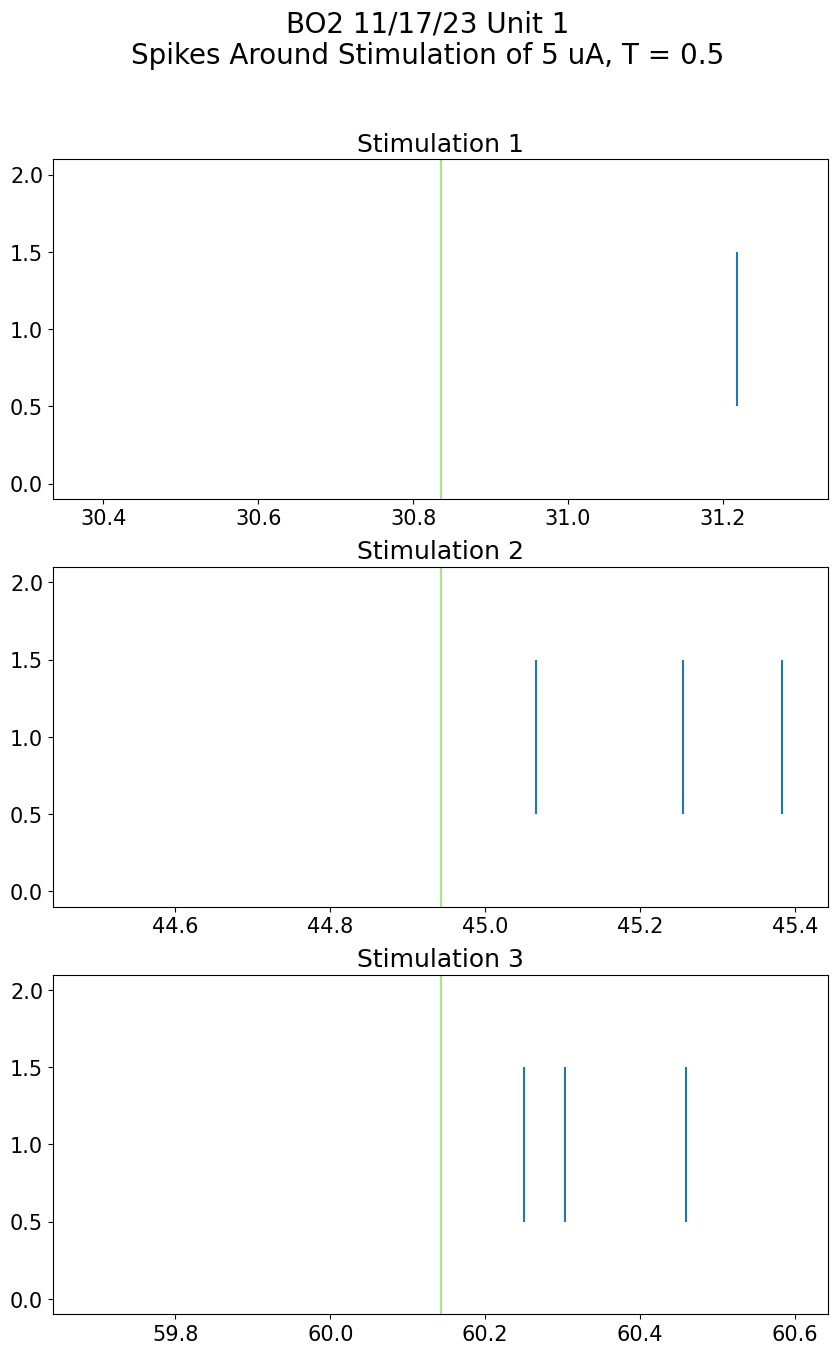

In [10]:
unit1_5uA_spikes_t1 = plot_stim_window(spiketimes_5uA_sec_unit1, 1, 5, stims_start_5uA, stims_end_5uA, 0.5)

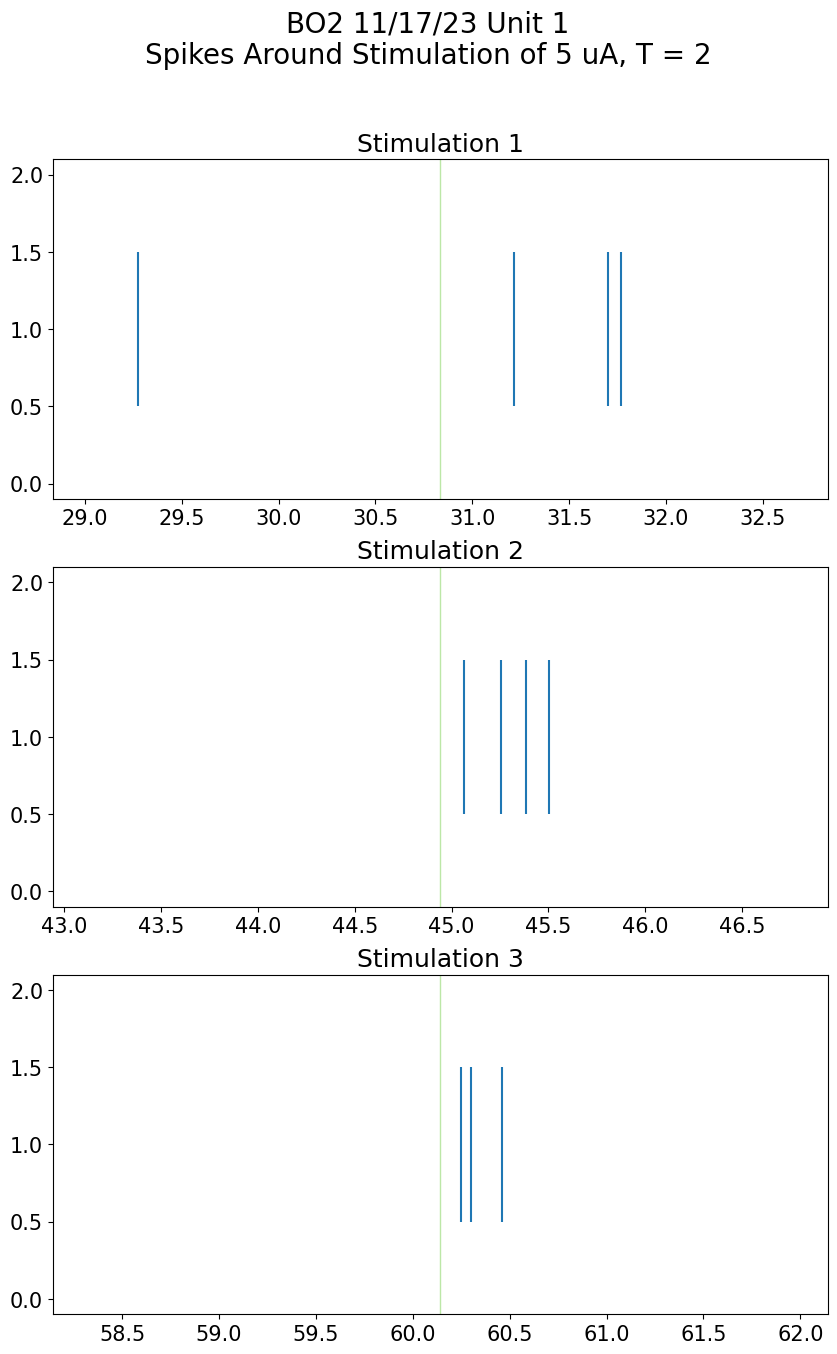

In [11]:
unit1_5uA_spikes_t2 = plot_stim_window(spiketimes_5uA_sec_unit1, 1, 5, stims_start_5uA, stims_end_5uA, 2)

## Unit 2

In [12]:
spiketimes_5uA_unit2, nwb_5uA_unit2 = pull_spike_data(fpath, 'BO2_231117_Stim5uA', 'BO2W1Stim_111723_5uA233uS.nwb', 1)
spiketimes_5uA_sec_unit2 = spiketimes_5uA_unit2 / 30000

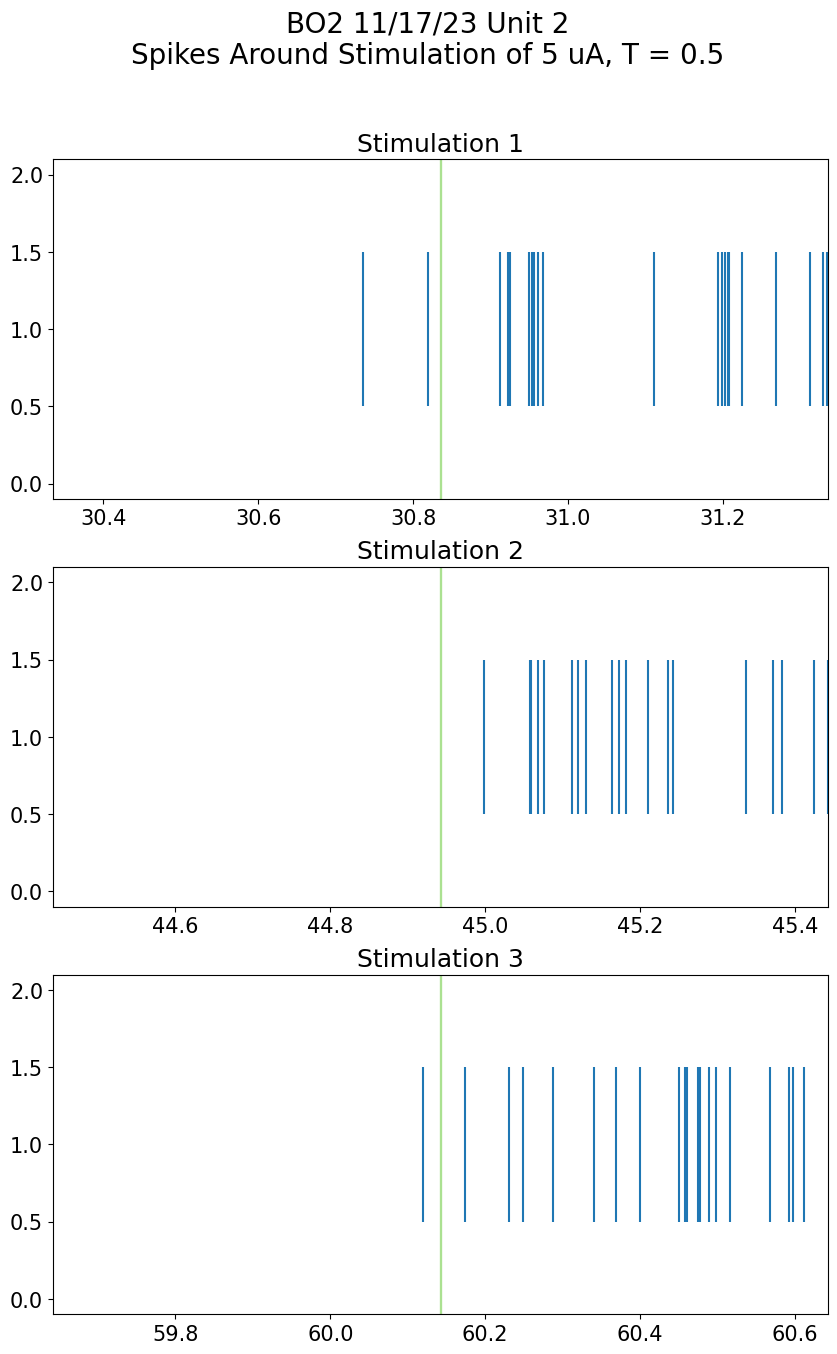

In [13]:
unit2_5uA_spikes_t1 = plot_stim_window(spiketimes_5uA_sec_unit2, 2, 5, stims_start_5uA, stims_end_5uA, 0.5)

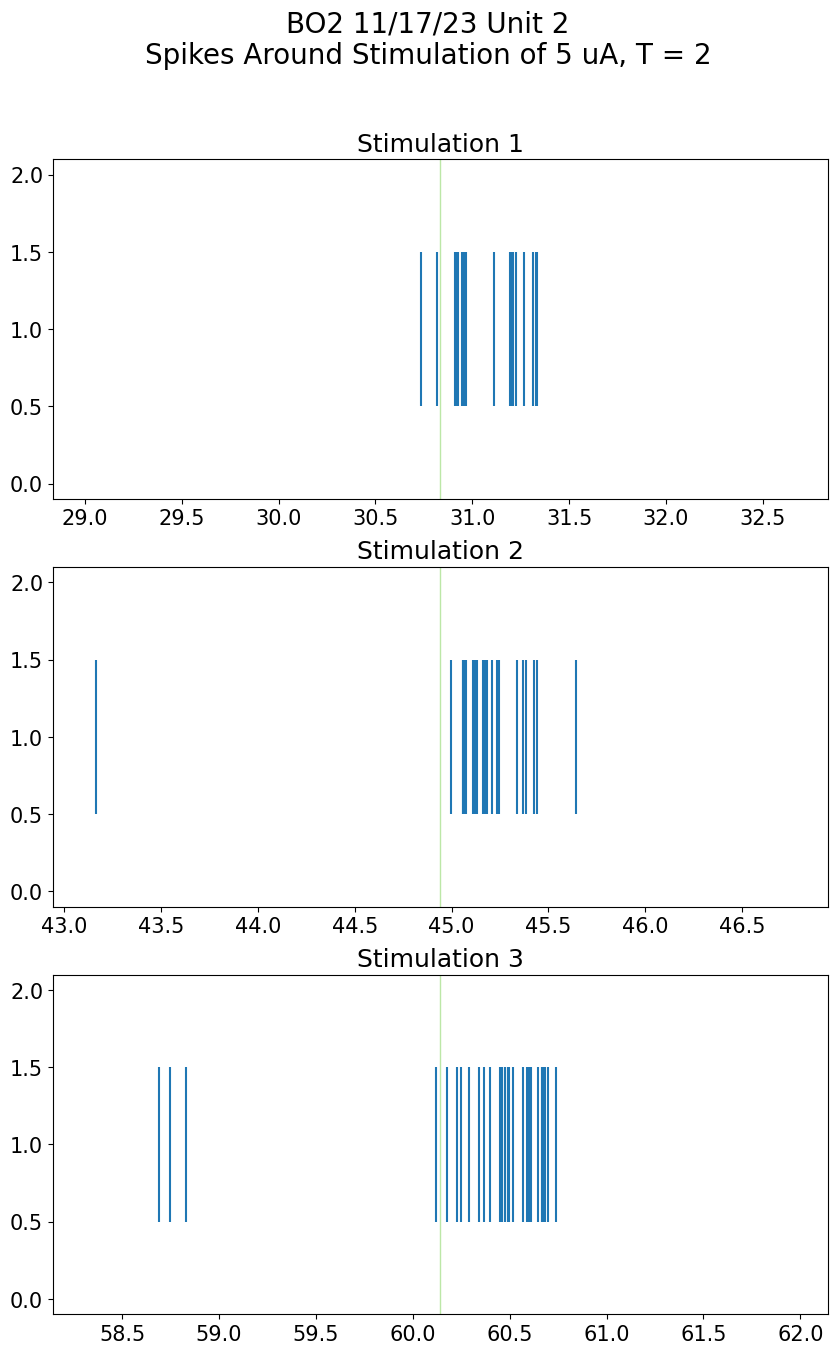

In [14]:
unit2_5uA_spikes_t2 = plot_stim_window(spiketimes_5uA_sec_unit2, 2, 5, stims_start_5uA, stims_end_5uA, 2)

# 10uA

This day had 3 main bursts of stimulation as follows
1) +/-0.01 @ 30.511833 - 30.512267 
2) +/-0.01 @ 45.184067 - 45.184500 
3) +/-0.01 @ 60.396733 - 60.397167 

In [15]:
stim1_start_10uA  = 30.511833
stim1_end_10uA  = 30.512267

stim2_start_10uA  = 45.184067
stim2_end_10uA  = 45.184500

stim3_start_10uA  = 60.396733
stim3_end_10uA  = 60.397167

In [16]:
stims_start_10uA = [stim1_start_10uA, stim2_start_10uA, stim3_start_10uA]

stims_end_10uA = [stim1_end_10uA, stim2_end_10uA, stim3_end_10uA]

## Unit 1

In [17]:
spiketimes_10uA_unit1, nwb_10uA_unit1 = pull_spike_data(fpath, 'BO2_231117_Stim10uA', 'BO2W1Stim_111723_10uA233uS.nwb', 0)
spiketimes_10uA_sec_unit1 = spiketimes_10uA_unit1 / 30000

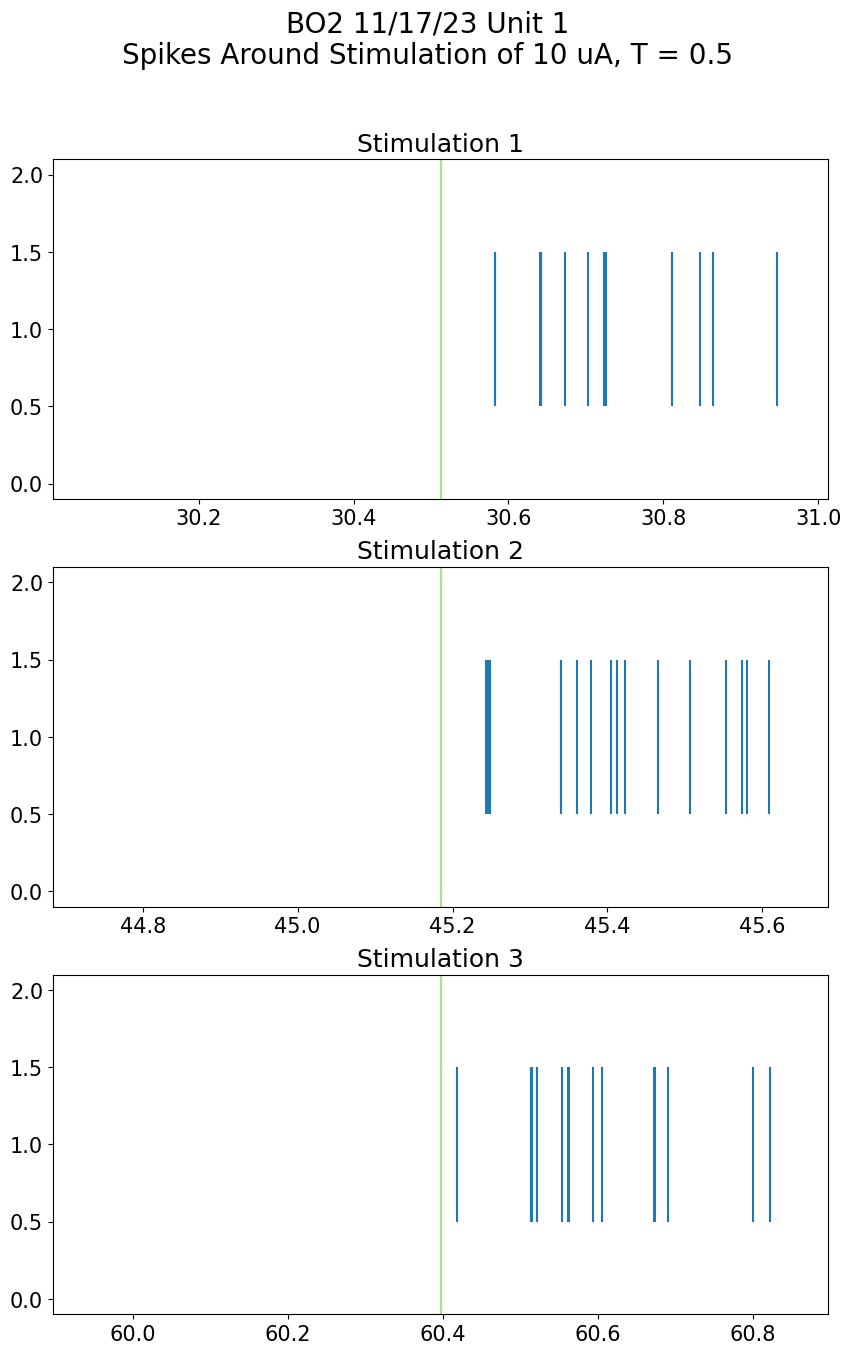

In [18]:
unit1_10uA_spikes_t1 = plot_stim_window(spiketimes_10uA_sec_unit1, 1, 10, stims_start_10uA, stims_end_10uA, 0.5)

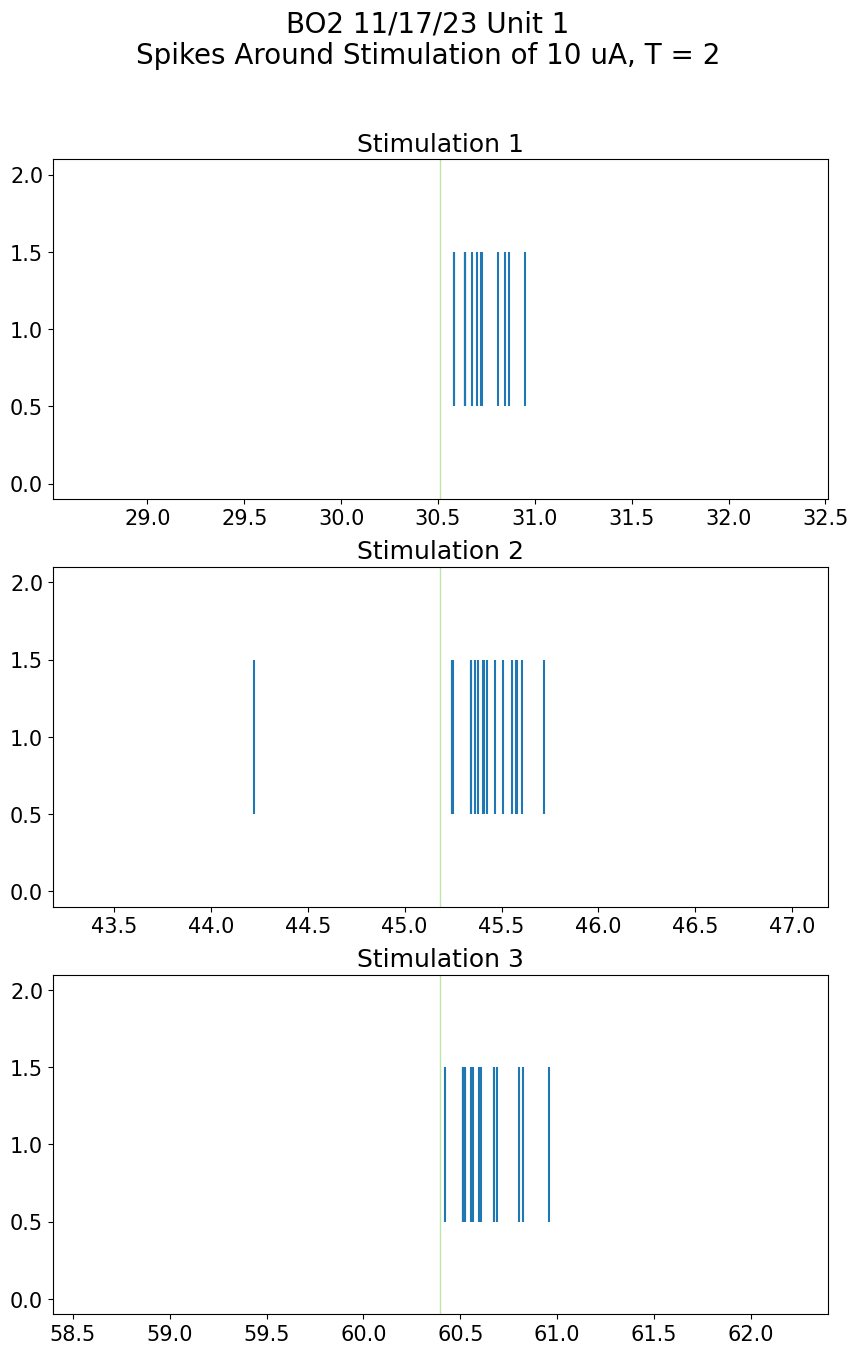

In [19]:
unit1_10uA_spikes_t2 = plot_stim_window(spiketimes_10uA_sec_unit1, 1, 10, stims_start_10uA, stims_end_10uA, 2)

## Unit 2

In [20]:
spiketimes_10uA_unit2, nwb_10uA_unit2 = pull_spike_data(fpath, 'BO2_231117_Stim10uA', 'BO2W1Stim_111723_10uA233uS.nwb', 1)
spiketimes_10uA_sec_unit2 = spiketimes_10uA_unit2 / 30000

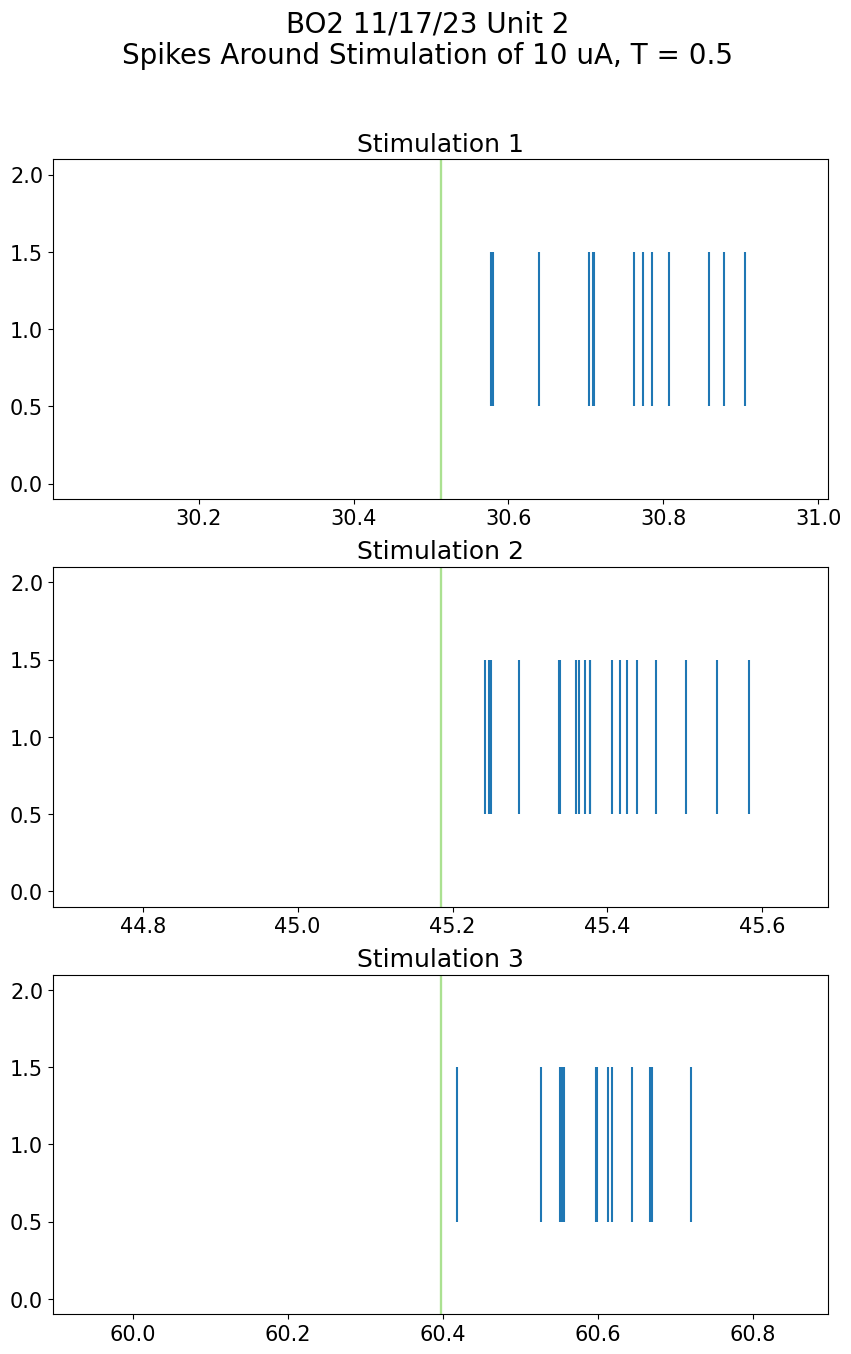

In [21]:
unit2_10uA_spikes_t1 = plot_stim_window(spiketimes_10uA_sec_unit2, 2, 10, stims_start_10uA, stims_end_10uA, 0.5)

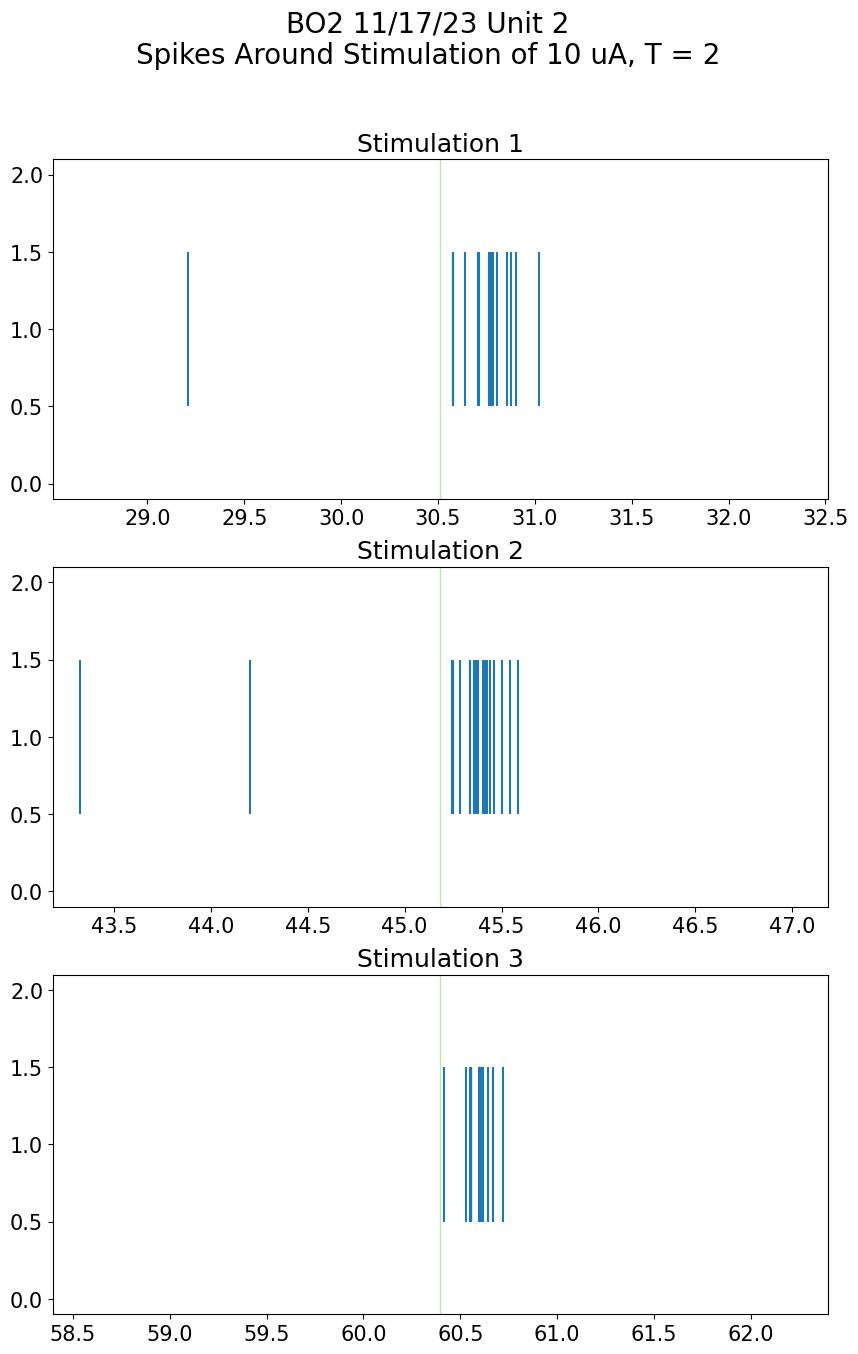

In [22]:
unit2_10uA_spikes_t2 = plot_stim_window(spiketimes_10uA_sec_unit2, 2, 10, stims_start_10uA, stims_end_10uA, 2)

# 20uA

This day had 3 main bursts of stimulation as follows
1) +/-0.02 @ 30.312767 - 30.313200 
2) +/-0.02 @ 45.600867 - 45.601300 
3) +/-0.02 @ 60.121567 - 60.122000 

In [23]:
stim1_start_20uA  = 30.312767
stim1_end_20uA  = 30.313200

stim2_start_20uA  = 45.600867
stim2_end_20uA  = 45.601300

stim3_start_20uA  = 60.121567
stim3_end_20uA  = 60.122000

In [24]:
stims_start_20uA = [stim1_start_20uA, stim2_start_20uA, stim3_start_20uA]

stims_end_20uA = [stim1_end_20uA, stim2_end_20uA, stim3_end_20uA]

## Unit 1

In [25]:
spiketimes_20uA_unit1, nwb_20uA_unit1 = pull_spike_data(fpath, 'BO2_231117_Stim20uA', 'BO2W1Stim_111723_20uA233uS.nwb', 0)
spiketimes_20uA_sec_unit1 = spiketimes_20uA_unit1 / 30000

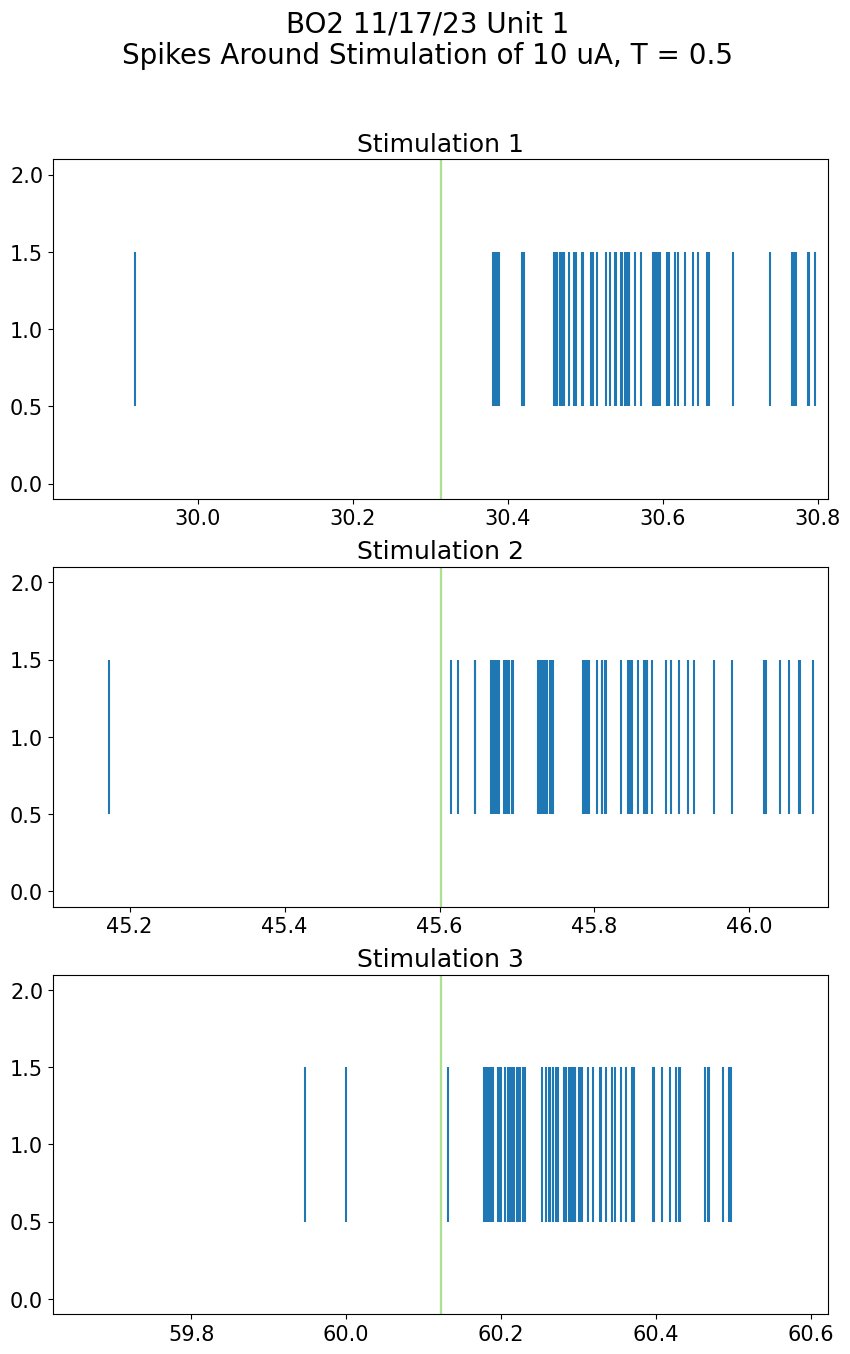

In [26]:
unit1_20uA_spikes_t1 = plot_stim_window(spiketimes_20uA_sec_unit1, 1, 10, stims_start_20uA, stims_end_20uA, 0.5)


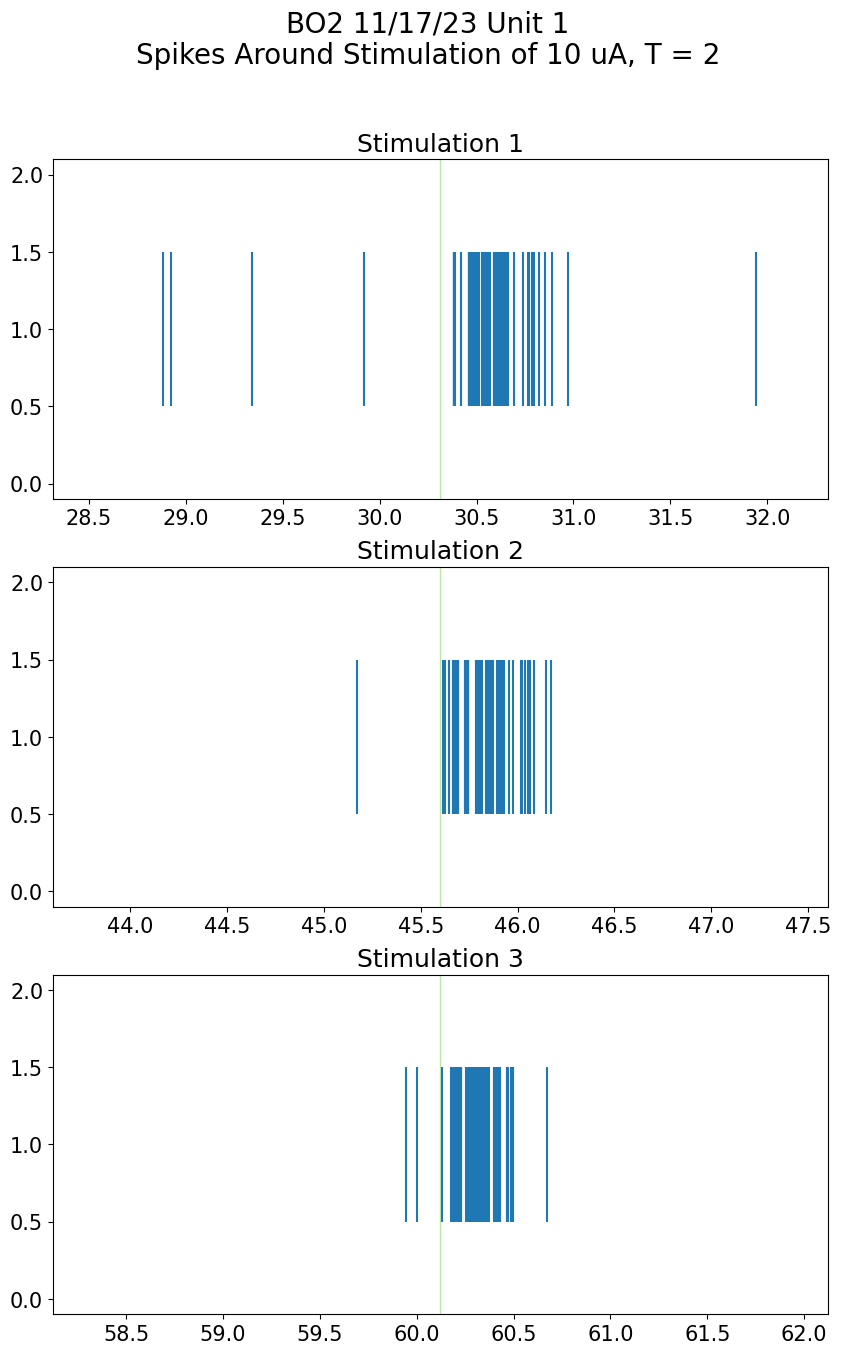

In [27]:
unit1_20uA_spikes_t2 = plot_stim_window(spiketimes_20uA_sec_unit1, 1, 10, stims_start_20uA, stims_end_20uA, 2)

## Unit 2

In [28]:
spiketimes_20uA_unit2, nwb_20uA_unit2 = pull_spike_data(fpath, 'BO2_231117_Stim20uA', 'BO2W1Stim_111723_20uA233uS.nwb', 1)
spiketimes_20uA_sec_unit2 = spiketimes_20uA_unit2 / 30000

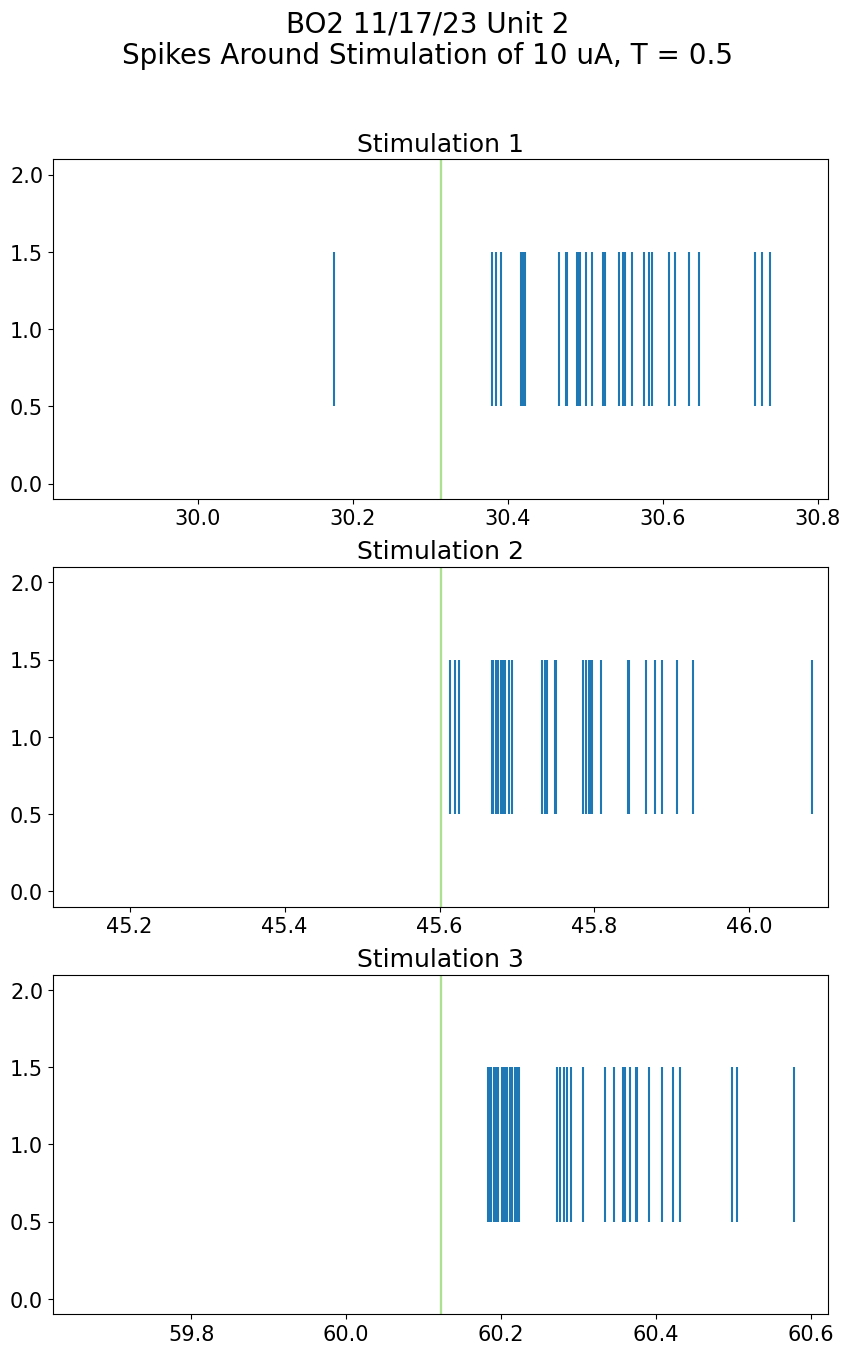

In [29]:
unit2_20uA_spikes_t1 = plot_stim_window(spiketimes_20uA_sec_unit2, 2, 10, stims_start_20uA, stims_end_20uA, 0.5)


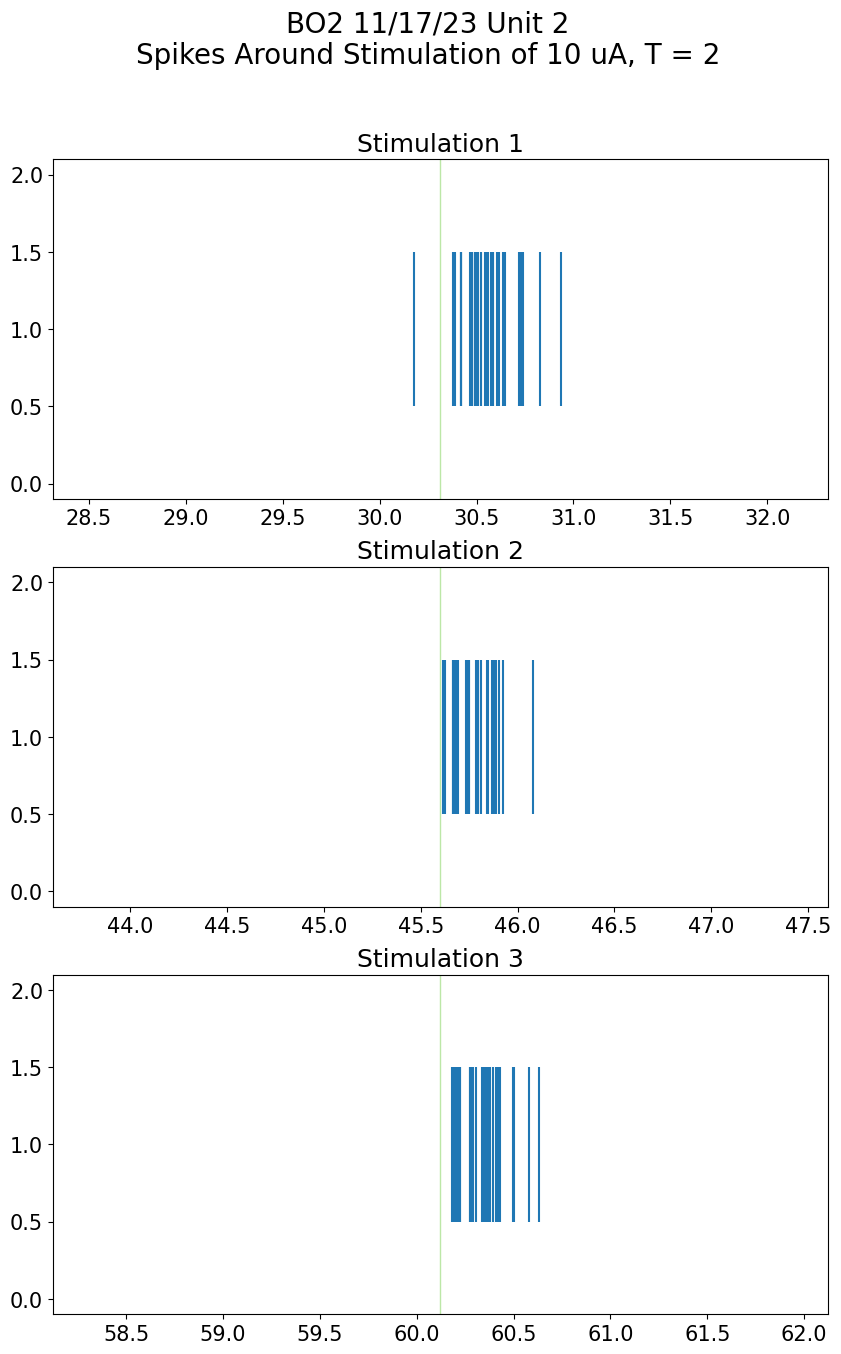

In [30]:
unit2_20uA_spikes_t2 = plot_stim_window(spiketimes_20uA_sec_unit2, 2, 10, stims_start_20uA, stims_end_20uA, 2)


# 30uA

This day had 3 main bursts of stimulation as follows
1) +/-0.03 @ 30.084300 - 30.084733 
2) +/-0.03 @ 45.485433 - 45.485867 
3) +/-0.03 @ 60.385367 - 60.385800 

In [31]:
stim1_start_30uA  = 30.084300
stim1_end_30uA  = 30.084733

stim2_start_30uA  = 45.485433
stim2_end_30uA  = 45.485867

stim3_start_30uA  = 60.385367
stim3_end_30uA  = 60.385800

In [32]:
stims_start_30uA = [stim1_start_30uA, stim2_start_30uA, stim3_start_30uA]

stims_end_30uA = [stim1_end_30uA, stim2_end_30uA, stim3_end_30uA]

## Unit 1

In [33]:
spiketimes_30uA_unit1, nwb_30uA_unit1 = pull_spike_data(fpath, 'BO2_231117_Stim30uA', 'BO2W1Stim_111723_30uA233uS.nwb', 0)
spiketimes_30uA_sec_unit1 = spiketimes_30uA_unit1 / 30000

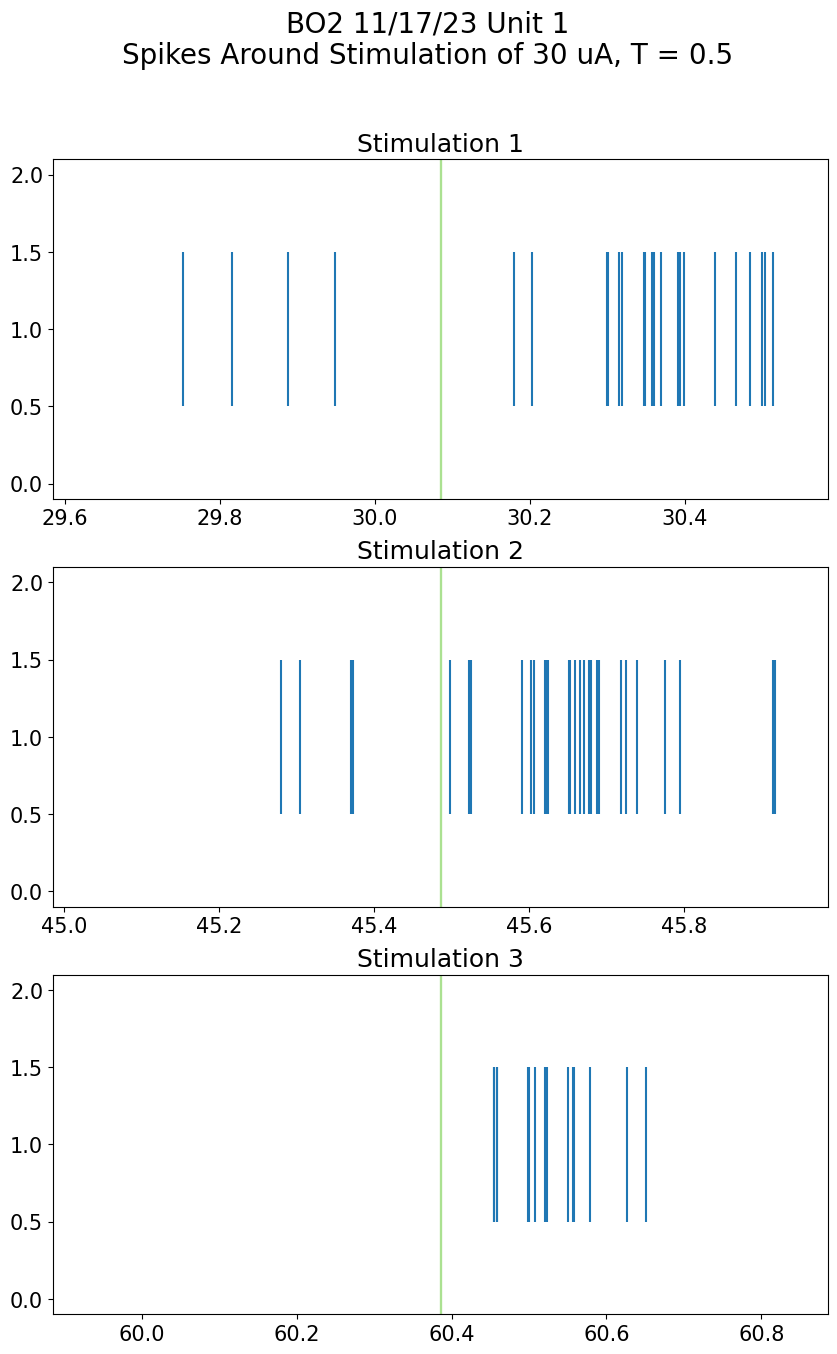

In [34]:
unit1_30uA_spikes_t1 = plot_stim_window(spiketimes_30uA_sec_unit1, 1, 30, stims_start_30uA, stims_end_30uA, 0.5)

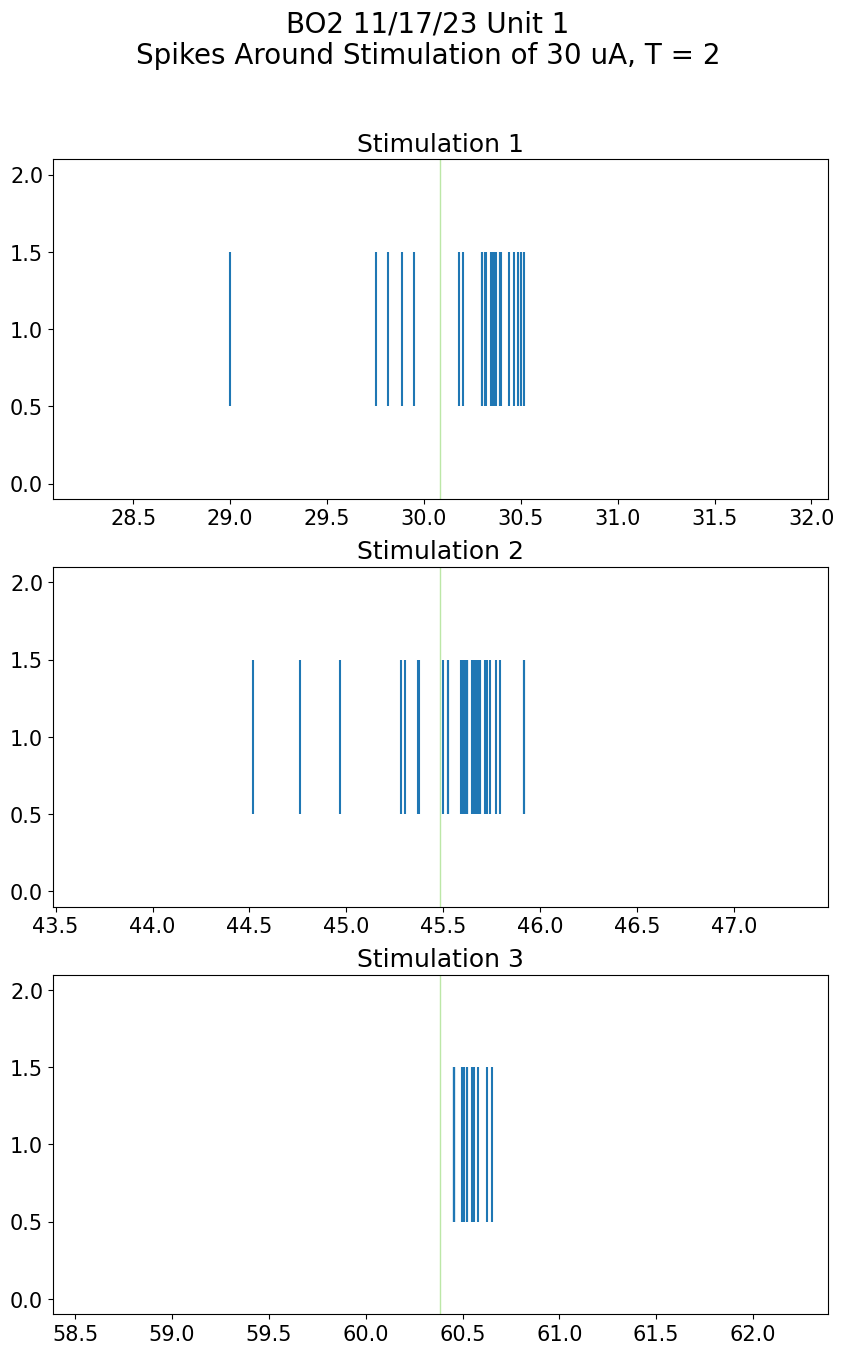

In [35]:
unit1_30uA_spikes_t2 = plot_stim_window(spiketimes_30uA_sec_unit1, 1, 30, stims_start_30uA, stims_end_30uA, 2)


## Unit 2

In [36]:
spiketimes_30uA_unit2, nwb_30uA_unit2 = pull_spike_data(fpath, 'BO2_231117_Stim30uA', 'BO2W1Stim_111723_30uA233uS.nwb', 1)
spiketimes_30uA_sec_unit2 = spiketimes_30uA_unit2 / 30000

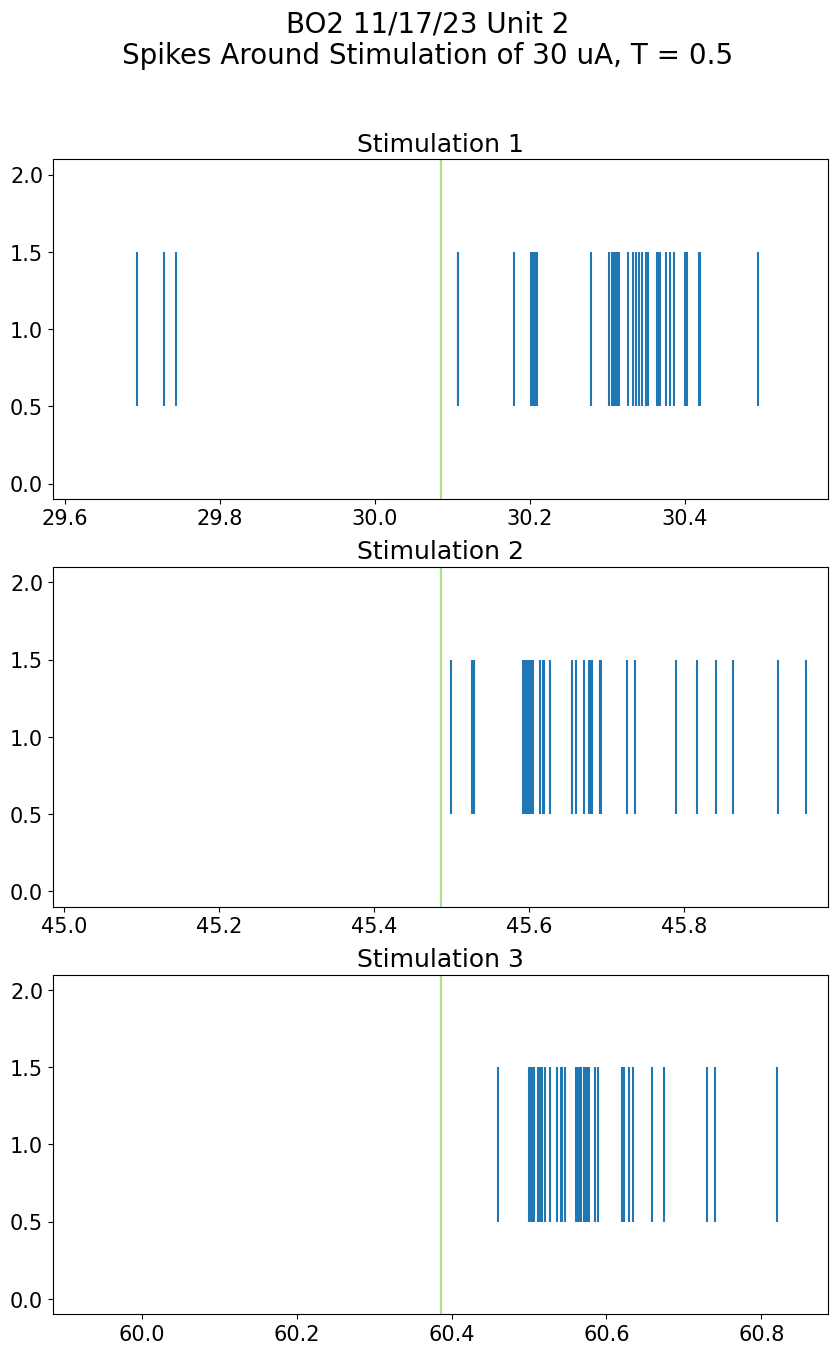

In [37]:
unit2_30uA_spikes_t1 = plot_stim_window(spiketimes_30uA_sec_unit2, 2, 30, stims_start_30uA, stims_end_30uA, 0.5)


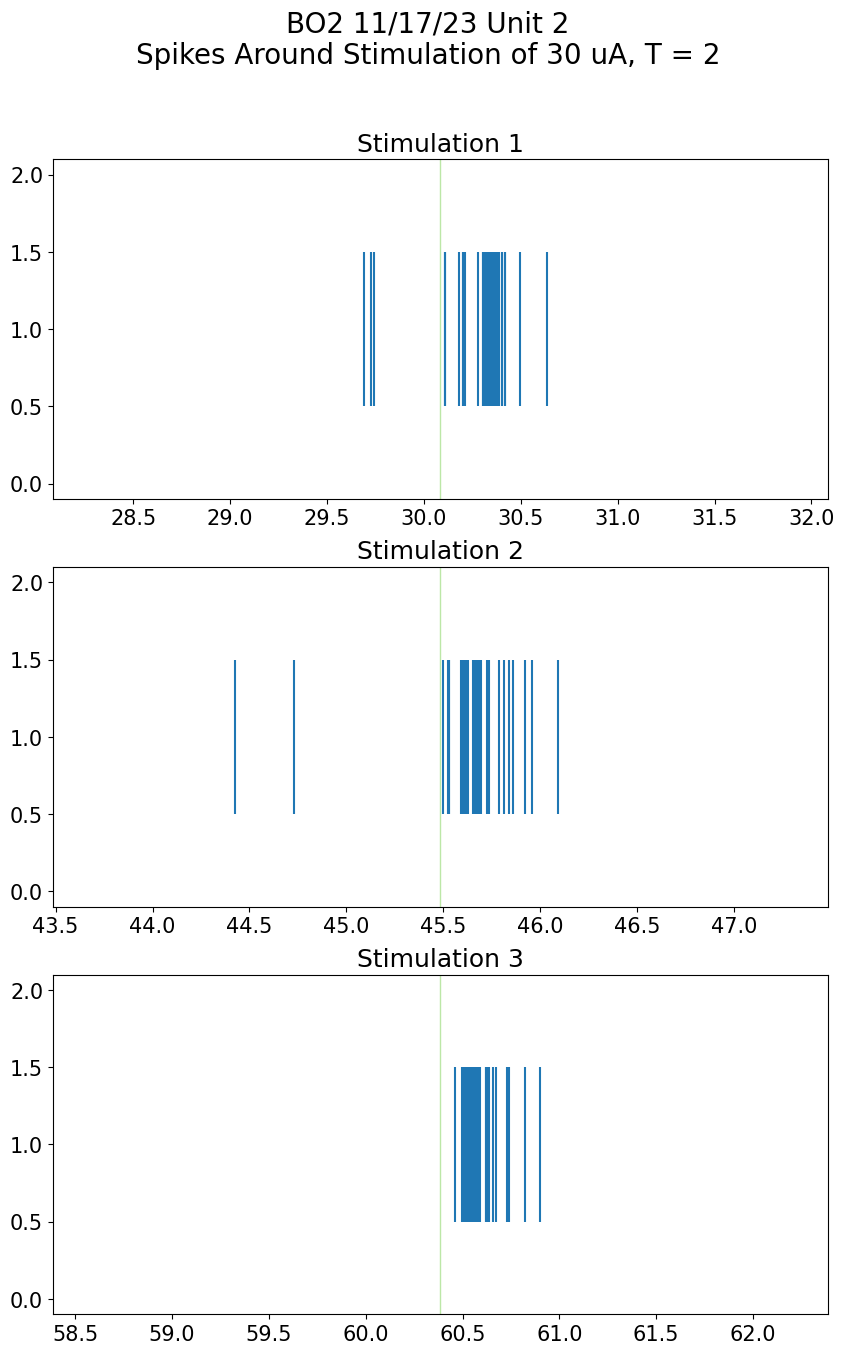

In [38]:
unit2_30uA_spikes_t2 = plot_stim_window(spiketimes_30uA_sec_unit2, 2, 30, stims_start_30uA, stims_end_30uA, 2)


# 40uA

This day had 3 main bursts of stimulation as follows
1) +/-0.04 @ 30.377233 - 30.377667
2) +/-0.04 @ 44.985433 - 44.985867
3) +/-0.04 @ 60.810367 - 60.810800

In [39]:
stim1_start_40uA  = 30.377233
stim1_end_40uA  = 30.377667

stim2_start_40uA  = 44.985433
stim2_end_40uA  = 44.985867

stim3_start_40uA  = 60.810367
stim3_end_40uA  = 60.810800

In [40]:
stims_start_40uA = [stim1_start_40uA, stim2_start_40uA, stim3_start_40uA]

stims_end_40uA = [stim1_end_40uA, stim2_end_40uA, stim3_end_40uA]

## Unit 1

In [41]:
spiketimes_40uA_unit1, nwb_40uA_unit1 = pull_spike_data(fpath, 'BO2_231117_Stim40uA', 'BO2W1Stim_111723_40uA233uS.nwb', 0)
spiketimes_40uA_sec_unit1 = spiketimes_40uA_unit1 / 30000

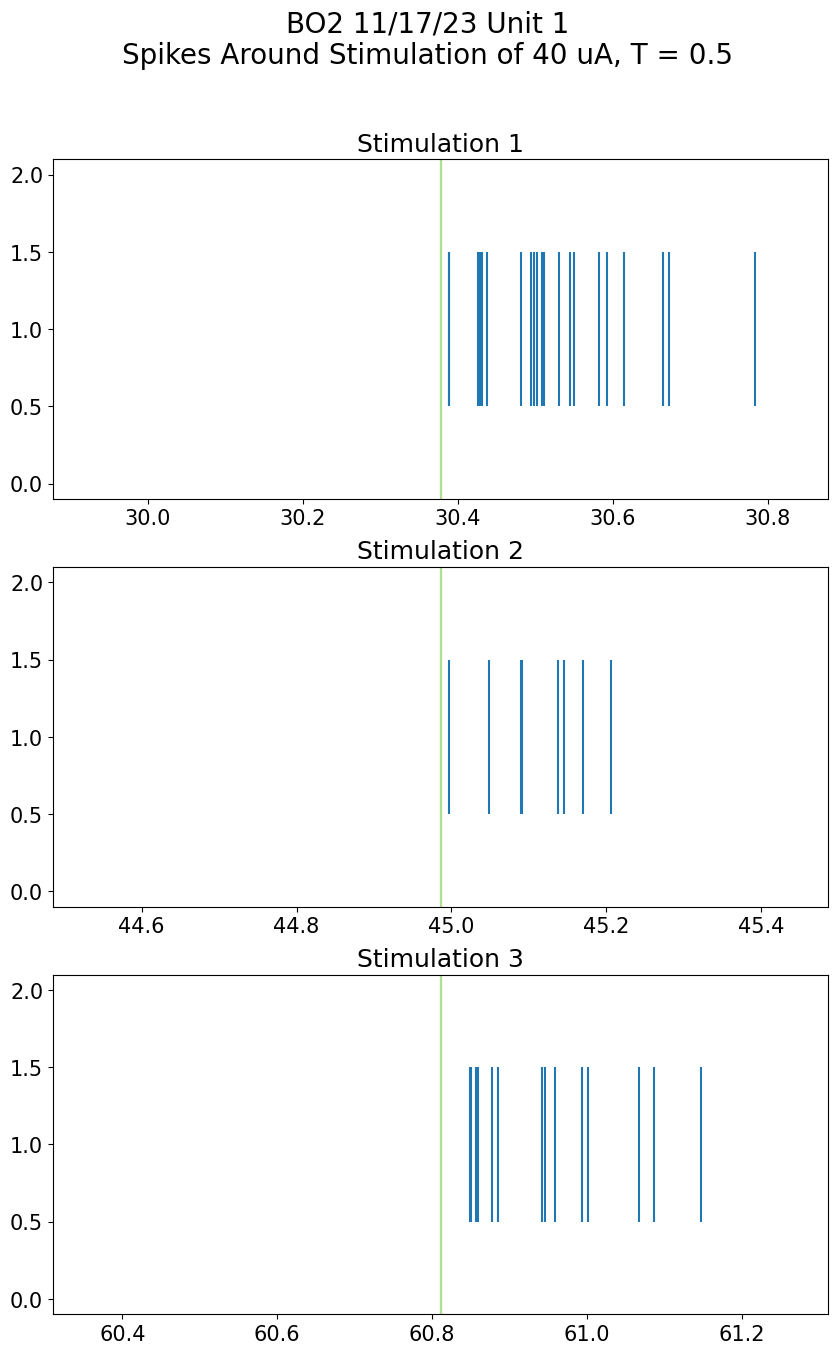

In [42]:
unit1_40uA_spikes_t1 = plot_stim_window(spiketimes_40uA_sec_unit1, 1, 40, stims_start_40uA, stims_end_40uA, 0.5)

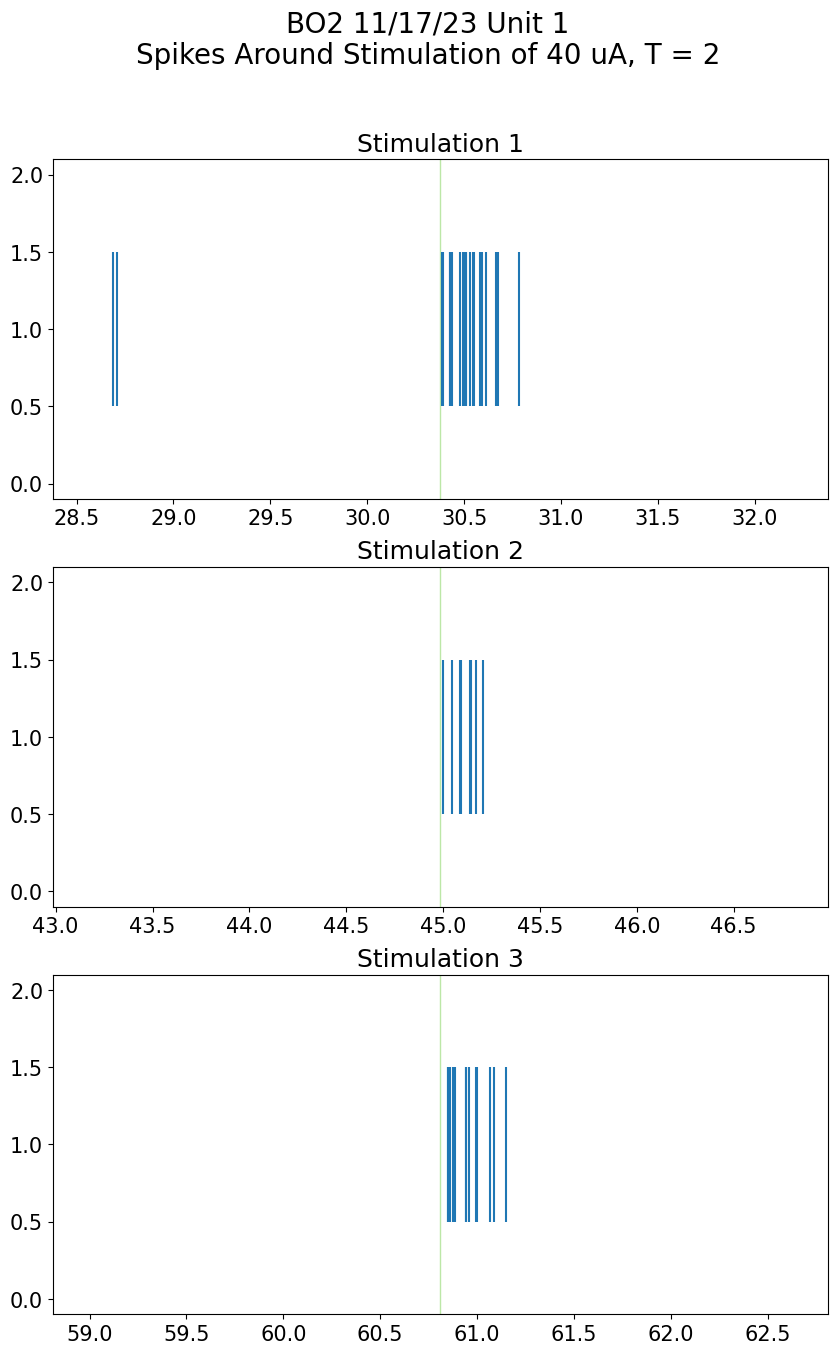

In [43]:
unit1_40uA_spikes_t2 = plot_stim_window(spiketimes_40uA_sec_unit1, 1, 40, stims_start_40uA, stims_end_40uA, 2)


## Unit 2

In [44]:
spiketimes_40uA_unit2, nwb_40uA_unit2 = pull_spike_data(fpath, 'BO2_231117_Stim40uA', 'BO2W1Stim_111723_40uA233uS.nwb', 1)
spiketimes_40uA_sec_unit2 = spiketimes_40uA_unit2 / 30000

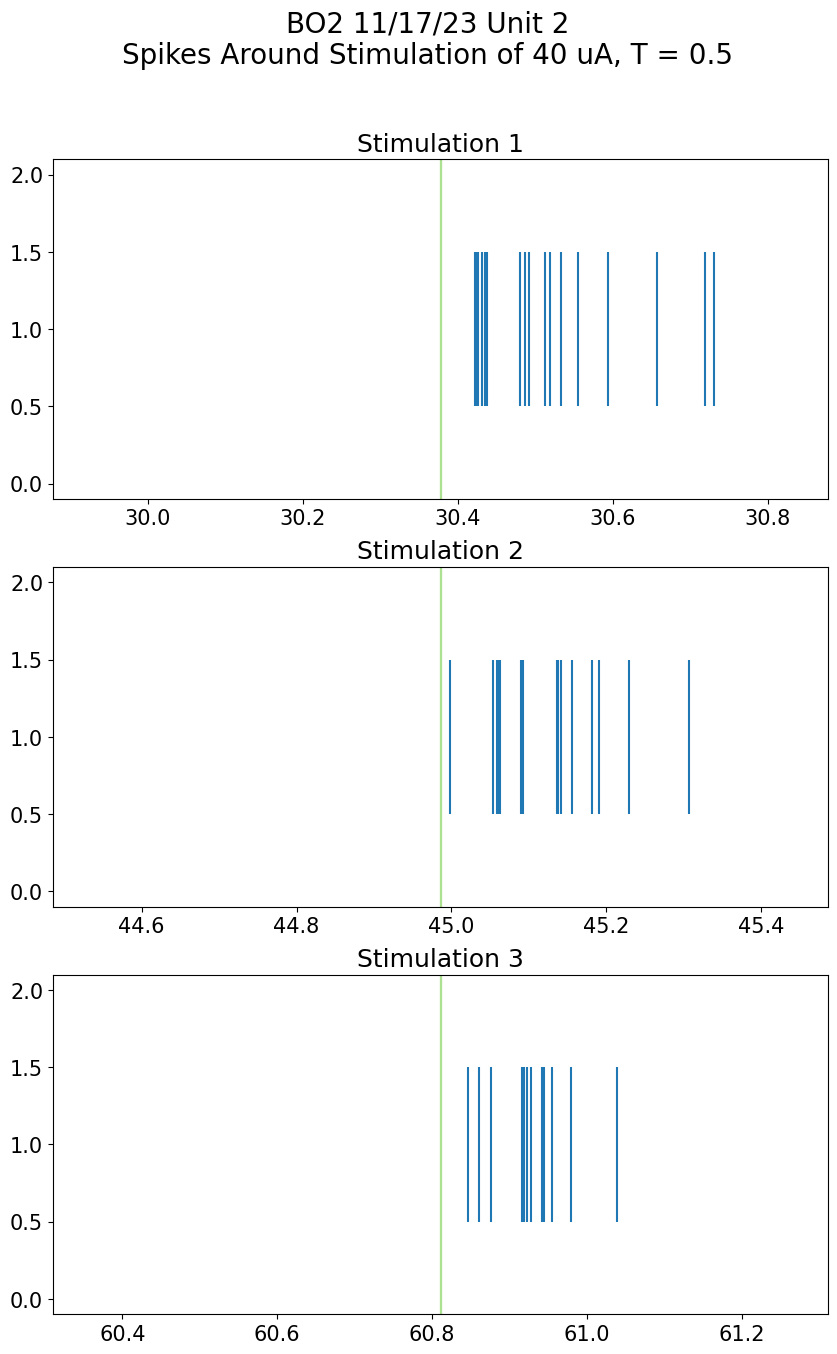

In [45]:
unit2_40uA_spikes_t1 = plot_stim_window(spiketimes_40uA_sec_unit2, 2, 40, stims_start_40uA, stims_end_40uA, 0.5)


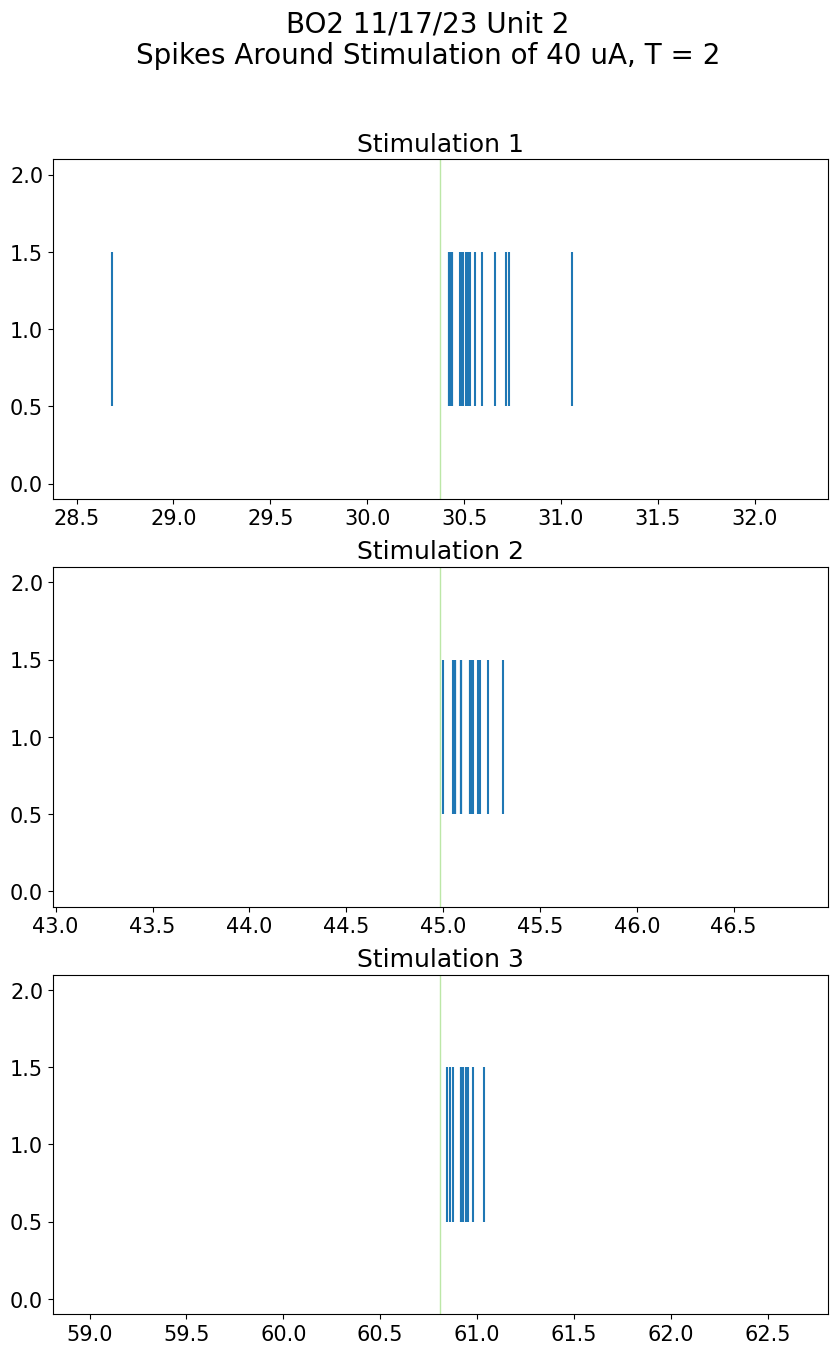

In [46]:
unit2_40uA_spikes_t2 = plot_stim_window(spiketimes_40uA_sec_unit2, 2, 40, stims_start_40uA, stims_end_40uA, 2)


# Note: 50uA and 60 uA were just noise units so not included in this analysis!

# Summary

In [47]:
stim_times = [[stims_start_5uA, stims_end_5uA],
              [stims_start_10uA, stims_end_10uA],
              [stims_start_20uA, stims_end_20uA],
              [stims_start_30uA, stims_end_30uA],
              [stims_start_40uA, stims_end_40uA]]

In [48]:
len(stim_times)

5

In [49]:
stim_times[0][0]

[30.835, 44.9418, 60.1419]

In [59]:
''' get number of pre- and post- stim spikes for 
    each unit in each val of sweep'''

# T=0.5
window_spikes_t1 = [[unit1_5uA_spikes_t1, unit2_5uA_spikes_t1], 
                    [unit1_10uA_spikes_t1, unit2_10uA_spikes_t1],
                    [unit1_20uA_spikes_t1, unit2_20uA_spikes_t1],
                    [unit1_30uA_spikes_t1, unit2_30uA_spikes_t1],
                    [unit1_40uA_spikes_t1, unit2_40uA_spikes_t1]]
num_pre_stim_t1 = []
num_post_stim_t1 = []
pre_post_diff_t1 = []

for i in np.arange(len(stim_times)):
    stims_start = stim_times[i][0]
    stims_end = stim_times[i][1]

    num_pre_stim = []
    num_post_stim = []
    pre_post_diff = []

    # individual units
    for unitspikes in window_spikes_t1[i]:
        # spike windows for each stim
        stim1_spikes = unitspikes[0]
        stim2_spikes = unitspikes[1]
        stim3_spikes = unitspikes[2]

        # num spikes pre-stim
        stim1_pre = len(stim1_spikes[stim1_spikes < stims_start[0]])
        stim2_pre = len(stim2_spikes[stim2_spikes < stims_start[1]])
        stim3_pre = len(stim3_spikes[stim3_spikes < stims_start[2]])
        npres = [stim1_pre, stim2_pre, stim3_pre]

        # num spikes post-stim
        stim1_post = len(stim1_spikes[stim1_spikes > stims_end[0]])
        stim2_post = len(stim2_spikes[stim2_spikes > stims_end[1]])
        stim3_post = len(stim3_spikes[stim3_spikes > stims_end[2]])
        npost = [stim1_post, stim2_post, stim3_post]

        # spike diff (in hz)
        stim1_diff = (stim1_post/0.5) - (stim1_pre/0.5)
        stim2_diff = (stim2_post/0.5) - (stim2_pre/0.5)
        stim3_diff = (stim3_post/0.5) - (stim3_pre/0.5)
        diff = [stim1_diff, stim2_diff, stim3_diff]

        num_pre_stim.append(npres)
        num_post_stim.append(npost)
        pre_post_diff.append(diff)
    
    num_pre_stim_t1.append(num_pre_stim)
    num_post_stim_t1.append(num_post_stim)
    pre_post_diff_t1.append(pre_post_diff)
        


In [60]:
pre_post_diff_t1 # sweep val < unit < stim

[[[2.0, 6.0, 6.0], [36.0, 38.0, 36.0]],
 [[26.0, 32.0, 32.0], [28.0, 38.0, 30.0]],
 [[126.0, 128.0, 140.0], [58.0, 62.0, 70.0]],
 [[32.0, 44.0, 30.0], [58.0, 66.0, 76.0]],
 [[42.0, 16.0, 28.0], [34.0, 32.0, 24.0]]]

In [61]:
stim5 = pre_post_diff_t1[0][0] + pre_post_diff_t1[0][1]
stim10 = pre_post_diff_t1[1][0] + pre_post_diff_t1[1][1]
stim20 = pre_post_diff_t1[2][0] + pre_post_diff_t1[2][1]
stim30 = pre_post_diff_t1[3][0] + pre_post_diff_t1[3][1]
stim40 = pre_post_diff_t1[4][0] + pre_post_diff_t1[4][1]

stims = [stim5, stim10, stim20, stim30, stim40]

In [62]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

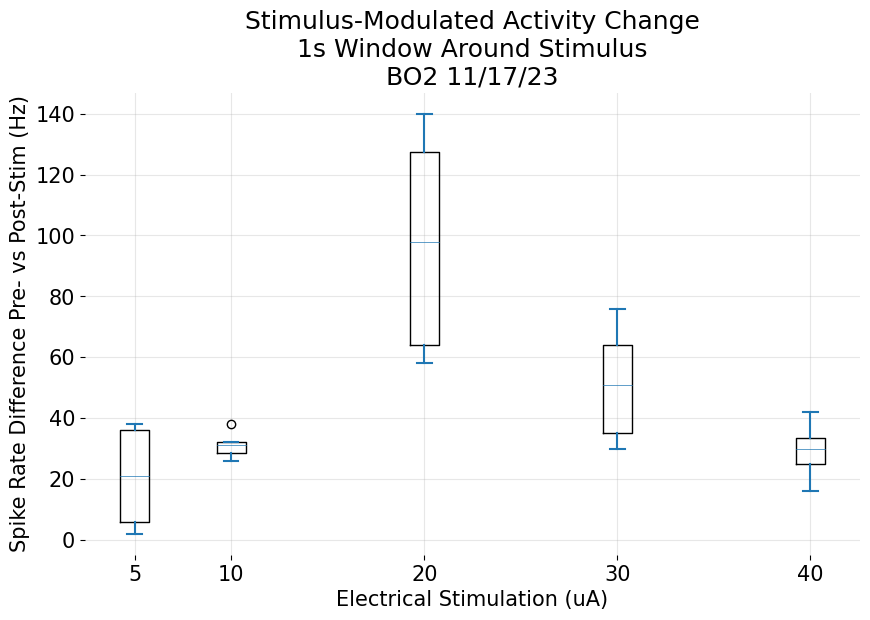

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.boxplot(stims, positions=[5, 10, 20, 30, 40], widths=1.5,
            medianprops={"color": "C0", "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
ax.set_title('Stimulus-Modulated Activity Change\n1s Window Around Stimulus\nBO2 11/17/23')
ax.set_xlabel('Electrical Stimulation (uA)')
ax.set_ylabel('Spike Rate Difference Pre- vs Post-Stim (Hz)')

ax.grid(True,which='major',axis='both',alpha=0.3)

In [55]:
# T=2
window_spikes_t2 = [[unit1_5uA_spikes_t2, unit2_5uA_spikes_t2], 
                    [unit1_10uA_spikes_t2, unit2_10uA_spikes_t2],
                    [unit1_20uA_spikes_t2, unit2_20uA_spikes_t2],
                    [unit1_30uA_spikes_t2, unit2_30uA_spikes_t2],
                    [unit1_40uA_spikes_t2, unit2_40uA_spikes_t2]]
num_pre_stim_t2 = []
num_post_stim_t2 = []
pre_post_diff_t2 = []

for i in np.arange(len(stim_times)):
    stims_start = stim_times[i][0]
    stims_end = stim_times[i][1]

    num_pre_stim = []
    num_post_stim = []
    pre_post_diff = []

    # individual units
    for unitspikes in window_spikes_t2[i]:
        # spike windows for each stim
        stim1_spikes = unitspikes[0]
        stim2_spikes = unitspikes[1]
        stim3_spikes = unitspikes[2]

        # num spikes pre-stim
        stim1_pre = len(stim1_spikes[stim1_spikes < stims_start[0]])
        stim2_pre = len(stim2_spikes[stim2_spikes < stims_start[1]])
        stim3_pre = len(stim3_spikes[stim3_spikes < stims_start[2]])
        npres = [stim1_pre, stim2_pre, stim3_pre]

        # num spikes post-stim
        stim1_post = len(stim1_spikes[stim1_spikes > stims_end[0]])
        stim2_post = len(stim2_spikes[stim2_spikes > stims_end[1]])
        stim3_post = len(stim3_spikes[stim3_spikes > stims_end[2]])
        npost = [stim1_post, stim2_post, stim3_post]

        # spike diff (hz) 
        stim1_diff = (stim1_post/2) - (stim1_pre/2)
        stim2_diff = (stim2_post/2) - (stim2_pre/2)
        stim3_diff = (stim3_post/2) - (stim3_pre/2)
        diff = [stim1_diff, stim2_diff, stim3_diff]

        num_pre_stim.append(npres)
        num_post_stim.append(npost)
        pre_post_diff.append(diff)
    
    num_pre_stim_t2.append(num_pre_stim)
    num_post_stim_t2.append(num_post_stim)
    pre_post_diff_t2.append(pre_post_diff)
        
print(num_pre_stim_t2)
print(num_post_stim_t2)
print(pre_post_diff_t2)

[[[1, 0, 0], [2, 1, 4]], [[0, 1, 0], [1, 2, 0]], [[4, 1, 2], [1, 0, 0]], [[5, 7, 0], [3, 2, 0]], [[2, 0, 0], [1, 0, 0]]]
[[[3, 4, 3], [20, 20, 26]], [[13, 17, 17], [15, 19, 15]], [[69, 67, 73], [32, 31, 36]], [[20, 26, 15], [33, 34, 39]], [[21, 8, 14], [18, 16, 12]]]
[[[1.0, 2.0, 1.5], [9.0, 9.5, 11.0]], [[6.5, 8.0, 8.5], [7.0, 8.5, 7.5]], [[32.5, 33.0, 35.5], [15.5, 15.5, 18.0]], [[7.5, 9.5, 7.5], [15.0, 16.0, 19.5]], [[9.5, 4.0, 7.0], [8.5, 8.0, 6.0]]]


In [56]:
pre_post_diff_t2 # sweep val < unit < stim

[[[1.0, 2.0, 1.5], [9.0, 9.5, 11.0]],
 [[6.5, 8.0, 8.5], [7.0, 8.5, 7.5]],
 [[32.5, 33.0, 35.5], [15.5, 15.5, 18.0]],
 [[7.5, 9.5, 7.5], [15.0, 16.0, 19.5]],
 [[9.5, 4.0, 7.0], [8.5, 8.0, 6.0]]]

In [57]:
stim5_t2 = pre_post_diff_t2[0][0] + pre_post_diff_t2[0][1]
stim10_t2 = pre_post_diff_t2[1][0] + pre_post_diff_t2[1][1]
stim20_t2 = pre_post_diff_t2[2][0] + pre_post_diff_t2[2][1]
stim30_t2 = pre_post_diff_t2[3][0] + pre_post_diff_t2[3][1]
stim40_t2 = pre_post_diff_t2[4][0] + pre_post_diff_t2[4][1]

stims_t2 = [stim5_t2, stim10_t2, stim20_t2, stim30_t2, stim40_t2]

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

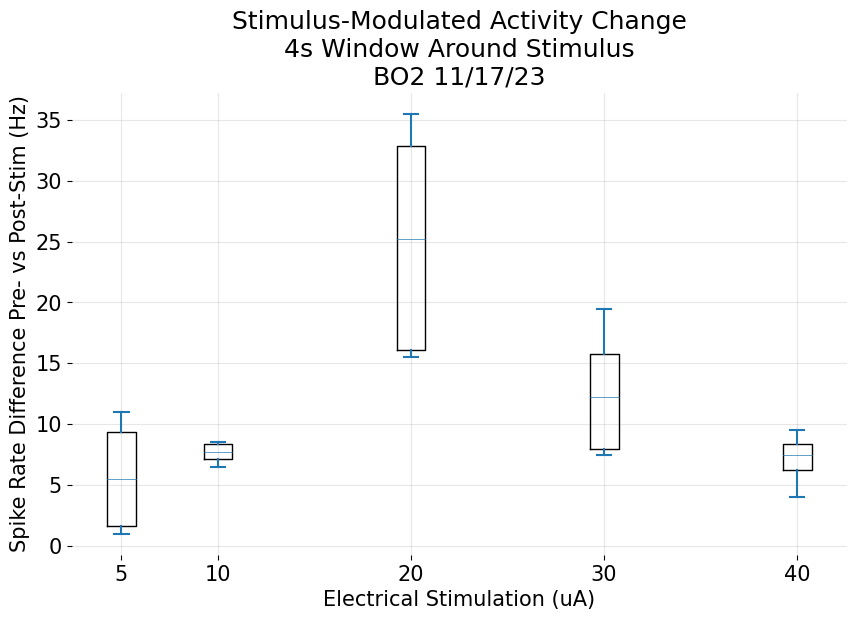

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.boxplot(stims_t2, positions=[5, 10, 20, 30, 40], widths=1.5,
            medianprops={"color": "C0", "linewidth": 0.5},
                whiskerprops={"color": "C0", "linewidth": 1.5},
                capprops={"color": "C0", "linewidth": 1.5})
ax.set_title('Stimulus-Modulated Activity Change\n4s Window Around Stimulus\nBO2 11/17/23')
ax.set_xlabel('Electrical Stimulation (uA)')
ax.set_ylabel('Spike Rate Difference Pre- vs Post-Stim (Hz)')

ax.grid(True,which='major',axis='both',alpha=0.3)